This model utilizes keras application ResNet50: https://keras.io/applications/#resnet
With the rest of the code adapted from *1. Standard CNN* model.

The model achieves 66.0% accuracy on test data.

In [0]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

from warnings import filterwarnings

np.random.seed(101)
filterwarnings('ignore')
sns.set_style('darkgrid')

**Setting data path**

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil
shutil.copy2("drive/My Drive/ISIC/ISIC_2019_Training_Input.zip", "./")

'./ISIC_2019_Training_Input.zip'

In [0]:
!unzip -q ISIC_2019_Training_Input.zip

In [0]:
base_loc = '/content/ISIC_2019_Training_Input'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_loc, '*.jpg'))}


In [0]:
%cd /content/ISIC_2019_Training_Input

/content/ISIC_2019_Training_Input


In [0]:
df_skin = pd.read_csv(os.path.join(base_loc, '/content/drive/My Drive/ISIC/full.csv'))
df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0


In [0]:
df_skin['image_path'] = df_skin['image'].map(image_paths.get)
df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val,image_path
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0012756...
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0012930...
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0013184...
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0013232...
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0,/content/ISIC_2019_Training_Input/ISIC_0013274...


In [0]:
lesion_types = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma'

}
df_skin['type'] = df_skin['diagnosis'].map(lesion_types.get)

# Converting the type to the categorical values
df_skin['type_id'] = pd.Categorical(df_skin['type']).codes

df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val,image_path,type,type_id
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0012756...,Melanoma,5
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0012930...,Melanoma,5
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0013184...,Melanoma,5
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0013232...,Melanoma,5
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0,/content/ISIC_2019_Training_Input/ISIC_0013274...,Melanocytic nevi,4


In [0]:
df_skin['skin_image'] = df_skin['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [0]:
df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val,image_path,type,type_id,skin_image
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0012756...,Melanoma,5,"[[[131, 122, 125], [147, 144, 153], [156, 151,..."
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0012930...,Melanoma,5,"[[[190, 162, 150], [193, 175, 165], [192, 174,..."
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0013184...,Melanoma,5,"[[[121, 114, 121], [140, 138, 151], [148, 147,..."
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0013232...,Melanoma,5,"[[[166, 125, 95], [166, 127, 94], [166, 141, 1..."
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0,/content/ISIC_2019_Training_Input/ISIC_0013274...,Melanocytic nevi,4,"[[[38, 42, 54], [33, 34, 54], [65, 60, 67], [1..."


In [0]:
features = df_skin.drop(columns=['type_id'],axis=1)
target = df_skin['type_id']

**Splitting data in 80/20 ratio**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 101)
print('The length of training set is {}\nThe length of testing set is {}\nThe ratio is {}'.format(len(X_train), len(X_test), '80/20'))

The length of training set is 20264
The length of testing set is 5067
The ratio is 80/20


**Normalization**

In [0]:
X_train = np.asarray(X_train['skin_image'].tolist())
X_test = np.asarray(X_test['skin_image'].tolist())
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

One Hot Encoding

In [0]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
y_train = to_categorical(y_train, num_classes= 8)
y_test = to_categorical(y_test, num_classes= 8)

In [0]:
y_test[:9]

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
print(X_train.shape)
print(X_test.shape)

(20264, 75, 100, 3)
(5067, 75, 100, 3)


**Proposed model**

In [0]:
# import keras library
import keras
from keras.models import Model
# import resnet50 application from keras library
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Input, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers, initializers
from keras.layers.advanced_activations import ReLU, Softmax
from keras.utils import plot_model
from keras.models import load_model

In [0]:
# download resnet50 application
# set up ResNet50 CNN network
# input shape corresponds to input matrix size
# include_top means whether to include the fully-connected layer at the top of the network. False enables pooling mode for feature extraction.
# average pooling is used
model = ResNet50(weights='imagenet', input_shape=(75, 100, 3), include_top=False, pooling="avg")













94658560/94653016 [==============================] - 3s 0us/step


In [0]:
model_output = model.output
#final layer is condensed to a 1D vector with length 8 
# and softmax activation function is used
output = Dense(8, activation='softmax')(model_output)
# Now the stem model is combined with the last layer
# The input is the same as before, but for the output an additional Dense layer was added
model = Model(inputs=model.input, outputs=output)

In [0]:
# To compile to model:
# Adam optimizer is used
# Since one-hot-ecoded vectors are used, the categorical cross entropy is used as loss and the metric is set to be top-1 accuracy
model.compile(Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# For each episode the input data is shuffled to create a different order for the inputs
# Batch size is set to be 32 meaning that there are 32 samples fed into the model per gradient update.
# 50 epochs mean that the model will be trained and iterated on the dataset for 50 times.
mod = model.fit(x = X_train, y = y_train, batch_size=32, shuffle=True, epochs= 50)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
20264/20264 [==============================] - 253s 12ms/step - loss: 1.2546 - acc: 0.5809
Epoch 2/50
20264/20264 [==============================] - 232s 11ms/step - loss: 1.2594 - acc: 0.5929
Epoch 3/50
20264/20264 [==============================] - 233s 11ms/step - loss: 1.0936 - acc: 0.6122
Epoch 4/50
20264/20264 [==============================] - 233s 11ms/step - loss: 1.0069 - acc: 0.6396
Epoch 5/50
20264/20264 [==============================] - 232s 11ms/step - loss: 1.1022 - acc: 0.6225
Epoch 6/50
20264/20264 [==============================] - 232s 11ms/step - loss: 1.0115 - acc: 0.6415
Epoch 7/50
20264/20264 [==============================] - 232s 11ms/step - loss: 1.0082 - acc: 0.6428
Epoch 8/50
20264/20264 [==============================] - 231s 11ms/step - loss: 0.9108 - acc: 0.6679
Epoch 9/50
20264/20264 [==============================] - 232s 11ms/step - loss: 0.875

In [0]:
model.save('skin.cr')

**Evaluation**

In [0]:
# Evaluate the accuracy and loss of the model on test dataset
# https://keras.io/models/model/#evaluate
loss,acc = model.evaluate(X_test, y_test)
print("The accuracy of the model is {:.3f}\nThe loss in the model is {:.3f}".format(acc,loss))

5067/5067 [==============================] - 15s 3ms/step
The accuracy of the model is 0.660
The loss in the model is 2.129


**The subsequent evaluation is not reflected in the report because this CNN model is not the top-performing one.**

It is left in the code just in case you are interested.

In [0]:
from keras.models import load_model
import itertools
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('skin.cr')

In [0]:
def plot_confusion_matrix_normalized(cm, classes,
                          normalize=True,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(None)

In [0]:
def plot_confusion_matrix_nonnormalized(cm, classes,
                          normalize=False,
                          title='Non-normalized confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(None)

In [0]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis = 1) 

In [0]:
y_true = np.argmax(y_test,1)

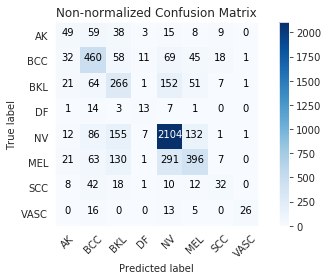

Normalized confusion matrix


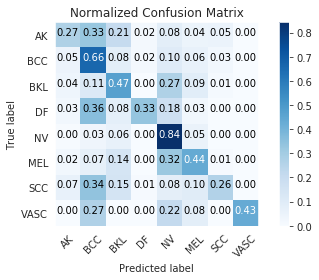

In [0]:
cm = confusion_matrix(y_true, y_pred)
classes = ['AK','BCC','BKL','DF','NV','MEL','SCC','VASC']

plot_confusion_matrix_nonnormalized(cm, classes, title='Non-normalized Confusion Matrix')
plt.show()

plot_confusion_matrix_normalized(cm, classes, title='Normalized Confusion Matrix')
plt.show()

In [0]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

          AK       0.34      0.27      0.30       181
         BCC       0.57      0.66      0.61       694
         BKL       0.40      0.47      0.43       563
          DF       0.35      0.33      0.34        39
          NV       0.79      0.84      0.82      2498
         MEL       0.61      0.44      0.51       909
         SCC       0.43      0.26      0.32       123
        VASC       0.90      0.43      0.58        60

    accuracy                           0.66      5067
   macro avg       0.55      0.46      0.49      5067
weighted avg       0.66      0.66      0.65      5067



**Visualizing Curves**

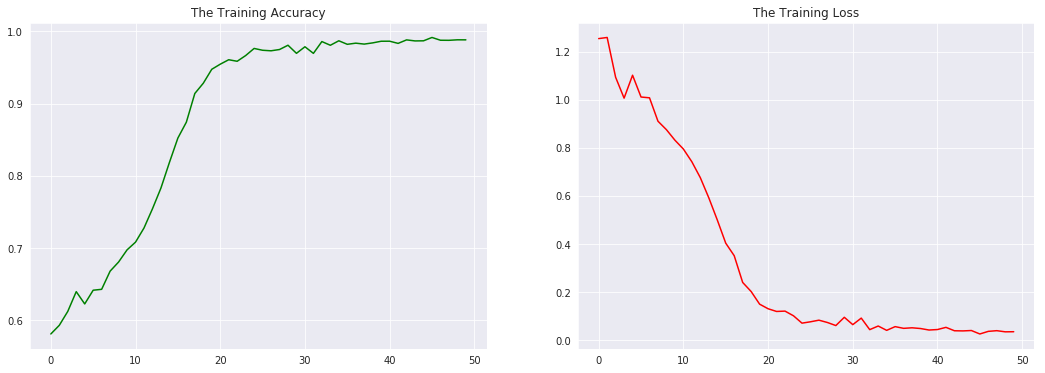

In [0]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(mod.history['acc'], color = 'green')
plt.title('The Training Accuracy')
plt.subplot(1,2,2)
plt.plot(mod.history['loss'], color = 'red')
plt.title('The Training Loss')
plt.show()

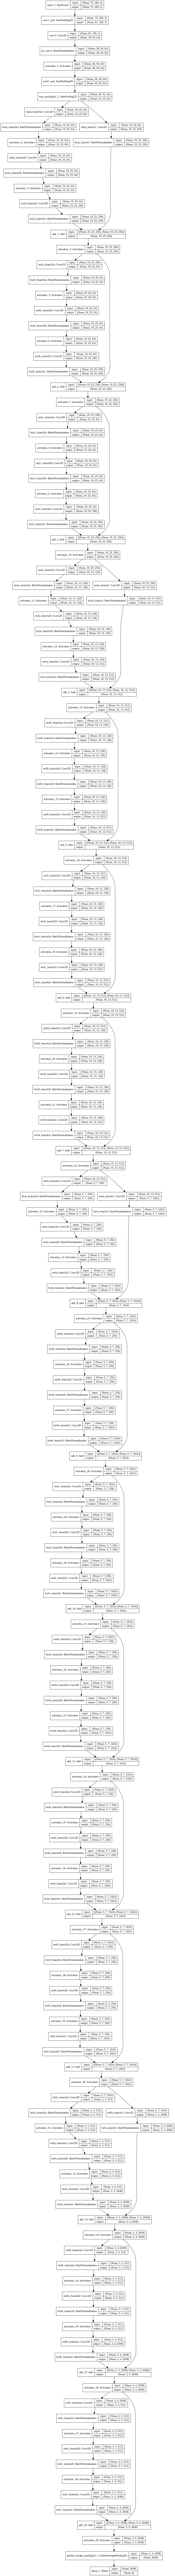

In [0]:
plot_model(model1, to_file='Resnet50_model_plot.png', show_shapes=True, show_layer_names=True)